# Tutorial: Semi-analytic calculation of neutrino leakage

## Author: Leo Werneck
### Special thanks to Ariadna Murguia-Berthier for sharing the code in which this tutorial notebook was based on.

In this tutorial notebook we study how a [neutrino leakage scheme](http://adsabs.harvard.edu/pdf/1996A%26A...311..532R) affects the evolution of [hydrodynamics](https://en.wikipedia.org/wiki/Fluid_dynamics) quantities in a simplified scenario. We assume an [isotropic gas](https://en.wikipedia.org/wiki/Kinetic_theory_of_gases) of constant density, temperature, and electron fraction in [flat spacetime](https://en.wikipedia.org/wiki/Minkowski_space) with no magnetic fields. In this case, the general relativistic [magnetohydrodynamics](https://en.wikipedia.org/wiki/Magnetohydrodynamics) (GRMHD) equations reduce to (cf. Eqs. 59 and 60 of [Murguia-Berthier *et al.*](https://arxiv.org/pdf/2106.05356.pdf))

$$
\newcommand{\me}{m_{\rm e}}
\newcommand{\nb}{n_{\rm b}}
\newcommand{\ee}{e^{-}}
\newcommand{\ae}{e^{+}}
\newcommand{\nue}{\nu_{\rm e}}
\newcommand{\anue}{\bar{\nu}_{\rm e}}
\newcommand{\nui}{\nu_{\rm i}}
\newcommand{\anui}{\bar{\nu}_{\rm i}}
\newcommand{\nux}{\nu_{\rm x}}
\newcommand{\anux}{\bar{\nu}_{\rm x}}
\newcommand{\rhob}{\rho_{\rm b}}
\newcommand{\ye}{Y_{\rm e}}
\newcommand{\QQ}{\mathcal{Q}}
\newcommand{\RR}{\mathcal{R}}
\begin{aligned}
\partial_{t}T^{t}_{\ \ t} &= \QQ,\\
\partial_{t}\ye &= \RR/\rhob,
\end{aligned}
$$

where $\rhob$ is the baryonic density, $\ye$ is the electron fraction, and $T^{\mu}_{\ \ \nu}$ is the energy-momentum of the gas. The source terms $\QQ$ and $\RR$ correspond to the energy loss and the emission/absorption rates due to [neutrinos and anti-neutrinos](https://en.wikipedia.org/wiki/Neutrino) of the reactions of the [$\beta$-processes](https://en.wikipedia.org/wiki/Beta_decay).

<a id='initialize_nrpy'></a>

# Step 1: Load necessary Python/NRPy+ modules \[Back to [Top](#toc)\]
$$\label{initialize_nrpy}$$

In [1]:
# Step 1: Load necessary Python/NRPy+ modules
import numpy as np
import astropy.constants as ct
import astropy.units as units
import fdint
import h5py as h5
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import interpn
from scipy.optimize import newton

# Step 1.a: Set useful physical constants
h          = ct.h.cgs.to("MeV s").value # MeV s
c          = ct.c.cgs.value             # cm / s
m_e_c2     = ct.m_e.cgs * ct.c.cgs**2
m_e_c2     = m_e_c2.to("MeV").value     # MeV
hc3        = (h*c)**3                   # MeV^3 cm^3
sigma_0    = 1.76e-44                   # cm^{-2}
N_A        = ct.N_A.cgs.value           # 1/mol
gamma_0    = 5.565e-2
alpha      = 1.23                       # https://arxiv.org/abs/1306.4953
Q_npmass   = 1.2935                     # https://arxiv.org/abs/1306.4953
alpha_f    = ct.alpha.value             # Fine-structure constant
Cv         = 0.5 + 2.0*0.23 # Vector coupling
Ca         = 0.5            # Axial coupling
CvCa_aux1  = ((Cv-Ca)**2 + (Cv+Ca)**2)/36.0
CvCa_aux2  = ((Cv-Ca)**2 + (Cv+Ca-2)**2)/9.0
MeV_to_erg = units.MeV.to('erg')
Br_const   = 2.0778e2 / MeV_to_erg
f_Br       = 0.5
amu        = ct.u.cgs.value             # Atomic mass unit (g)

# Step 1.b: Compute beta (Eq. A6 of https://arxiv.org/abs/1306.4953)
beta = np.pi * c *(1+3*alpha**2)*sigma_0/(hc3*m_e_c2**2)

# Step 1.c: Additional unit converting factors
G    = ct.G.cgs.value
Msun = ct.M_sun.cgs.value
geom_to_cgs__length  = G * Msun / c**2
geom_to_cgs__density = Msun / geom_to_cgs__length**3

# Step 1.d: Read in EOS table
EOS_table_filepath = "/home/leo/Codes/eos_tables/LS220_234r_136t_50y_analmu_20091212_SVNr26.h5"

<a id='numerical_implementation'></a>

# Step 2: Numerical implementation \[Back to [Top](#toc)\]
$$\label{numerical_implementation}$$

We now provide the numerical implementation of the source terms $\RR$ and $\QQ$.

<a id='numerical_implementation'></a>

# Step 2.a: Equation of state table interpolation
$$\label{numerical_implementation}$$

In [15]:
# import bisection
# Step 2.a: Equation of state interpolation functions
with h5.File(EOS_table_filepath) as EOS_table:

    # Step 2.a.i: Read from table
    table_rho  = 10**np.array(EOS_table['logrho'])[:]
    table_T    = 10**np.array(EOS_table['logtemp'])[:]
    table_P    = 10**np.array(EOS_table['logpress'])[:]
    table_eps  = 10**np.array(EOS_table['logenergy'])[:] - np.array(EOS_table['energy_shift'])[:]
    table_Y_e  = np.array(EOS_table['ye'])[:]
    table_X_n  = np.array(EOS_table['Xn'])[:]
    table_X_p  = np.array(EOS_table['Xp'])[:]
    table_mu_e = np.array(EOS_table['mu_e'])[:]
    table_mu_n = np.array(EOS_table['mu_n'])[:]
    table_mu_p = np.array(EOS_table['mu_p'])[:]

    # Step 2.a.ii: Convert rho, Y_e, and T to log base e
    table_lnrho = np.log(table_rho)
    table_lnT   = np.log(table_T)
    
    # Step 2.a.iii: Define the interpolators
    table_points       = (table_Y_e,table_lnT,table_lnrho)
    P_interpolator     = rgi(points, table_P)
    eps_interpolator   = rgi(points, table_eps)
    X_n_interpolator   = rgi(points, table_X_n)
    X_p_interpolator   = rgi(points, table_X_p)
    mu_e_interpolator  = rgi(points, table_mu_e)
    mu_n_interpolator  = rgi(points, table_mu_n)
    mu_p_interpolator  = rgi(points, table_mu_p)

# Step 2.a.iv: Define the EOS interpolating functions
def EOS_interpolate(rho_b,Y_e,T):
    point = [Y_e,np.log(T),np.log(rho_b)]
    X_n   = X_n_interpolator(point)[0]
    X_p   = X_p_interpolator(point)[0]
    mu_e  = mu_e_interpolator(point)[0]
    mu_n  = mu_n_interpolator(point)[0]
    mu_p  = mu_p_interpolator(point)[0]
    
    return X_n, X_p, mu_e, mu_n, mu_p

# Step 2.a.v: Get pressure and specific internal energy
def EOS_get_P_and_eps(rho_b,Y_e,T):
    point = [Y_e,np.log(T),np.log(rho_b)]
    P     = P_interpolator(point)[0]
    eps   = eps_interpolator(point)[0]
    return P, eps

# Step 2.a.vi: Get temperature from specific internal energy
def EOS_Newton_Raphson_eps_of_rho_Ye_and_T(T_in,rho_in,Y_e_in,eps_in):
    return eps_in-interpn((table_Y_e,table_T,table_rho), table_eps, (Y_e_in,T_in,rho_in))

def EOS_get_T_from_rho_Ye_and_eps(rho_in, Y_e_in, eps_in):
    T_in = 1.0
    root = newton(EOS_Newton_Raphson_eps_of_rho_Ye_and_T, T_in, maxiter=10000, args=(rho_in,Y_e_in,eps_in))
    return root[0]

<a id='electron_capture'></a>

## Step 2.b: Electron capture: computing $\RR_{\rm ec}$ and $\QQ_{\rm ec}$ \[Back to [Top](#toc)\]
$$\label{electron_capture}$$

We now compute the neutrino emission and cooling rates for the electron capture (ec) by a proton, $\RR_{\rm ec}$ and $\QQ_{\rm ec}$, respectively, which arise from the reaction

$$
\ee + p \to n + \nue,
$$

where $\ee$, $p$, $n$, and $\nue$ are the electron, proton, neutron, and electron neutrino, respectively. The rates are given by Eqs. (A5) and (A6) of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953),

$$
\begin{align}
\RR_{\rm ec}(\nue) &= \beta\eta_{\rm np}T^{5}F_{4}(\eta_{\rm e})\left[1-f_{\nue}\right]_{\rm ec},\\
\QQ_{\rm ec}(\nue) &= \beta\eta_{\rm np}T^{6}F_{5}(\eta_{\rm e})\left[1-f_{\nue}\right]_{\rm ec},
\end{align}
$$

where $\rhob$ is the baryonic density, $T$ is the temperature, and $F_{n}$ are Fermi-Dirac integrals,

$$
F_{n}(\eta) = \int_{0}^{\infty}\frac{x^{n}dx}{e^{x-\eta}+1}.
$$

Moreover, we have

$$
\beta = \frac{\pi}{h^{3}c^{2}}\frac{1+3\alpha^{2}}{\me^{2} c^{4}}\sigma_{0},
$$

where $h$ is the [Planck constant](https://en.wikipedia.org/wiki/Planck_constant), $c$ is the [speed of light](https://en.wikipedia.org/wiki/Speed_of_light), $\me$ is the electron mass, $\sigma_{0} \approx 1.705 \times 10^{-44}\ {\rm cm^{2}}$ ([Ruffert *et al.* (1996)](http://adsabs.harvard.edu/pdf/1996A%26A...311..532R) use $\sigma_{0} \approx 1.76 \times 10^{-44}\ {\rm cm^{2}}$), the weak axial-vector coupling constant is $\alpha\approx1.23$ ([Ruffert *et al.* (1996)](http://adsabs.harvard.edu/pdf/1996A%26A...311..532R) use $\alpha\approx1.25$), $\eta_{i}\equiv\mu_{i}/T$ are the degeneracy parameters for different particle species, and

$$
\eta_{\rm np} = \frac{n_{\rm n}-n_{\rm p}}{e^{\hat\eta}-1} = N_{A}\rhob\left(\frac{X_{\rm n}-X_{\rm p}}{e^{\hat\eta}-1}\right),
$$

is the Pauli blocking factor, where $n_{\rm n}$ and $n_{\rm p}$ are the neutron and proton number densities, respectively, and $\hat\eta=\eta_{\rm n}-\eta_{\rm p} - Q/T$ is the difference between neutron and proton relativistic degeneracy parameters, with $Q = 1.2935\ {\rm MeV}$ the [rest-mass-energy](https://en.wikipedia.org/wiki/Mass_in_special_relativity) difference between a neutron and a proton. For densities smaller than $1\times10^{11}\ {\rm g\,cm^{-3}}$, we use $n_{\rm np}\approx n_{\rm p} = N_{A}\rhob X_{\rm p}$ instead. Temperatures are given in MeV.

We also use the approximate expression (cf. Eqs. A9 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\begin{align}
\left[1-f_{\nue}\right]_{\rm ec} \approx \left\{1 + \exp\left[-\frac{F_{5}(\eta_{\rm e})}{F_{4}(\eta_{\rm e})}-\eta_{\nue}\right]\right\}^{-1},
\end{align}
$$

where

$$
\eta_{\nue} = -\eta_{\anue} = \eta_{\rm e} + \eta_{\rm p} - \eta_{\rm n}.
$$

We also compute the neutrino emission and cooling rates for the positron capture (pc) by a neutron, $\RR_{\rm pc}$ and $\QQ_{\rm pc}$, respectively, which arise from the reaction

$$
\ae + n \to p + \anue,
$$

where $\ae$ and $\anue$ are the positron and the electron antineutrino, respectively. The rates are given by Eqs. (A2) and (A3) of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953),

$$
\begin{align}
\RR_{\rm pc}(\anue) &= \beta\,\eta_{\rm pn}T^{5}F_{4}(-\eta_{\rm e})\left[1-f_{\anue}\right]_{\rm pc},\\
\QQ_{\rm pc}(\anue) &= \beta\,\eta_{\rm pn}T^{6}F_{5}(-\eta_{\rm e})\left[1-f_{\anue}\right]_{\rm pc},
\end{align}
$$

where

$$
\left[1-f_{\anue}\right]_{\rm pc} \approx \left\{1 + \exp\left[-\frac{F_{5}(-\eta_{\rm e})}{F_{4}(-\eta_{\rm e})}-\eta_{\anue}\right]\right\}^{-1},
$$

and

$$
\eta_{\rm pn} = \frac{n_{\rm p}-n_{\rm n}}{e^{-\hat\eta}-1} = N_{A}\rhob\left(\frac{X_{\rm p}-X_{\rm n}}{e^{-\hat\eta}-1}\right).
$$

For densities smaller than $1\times10^{11}\ {\rm g\,cm^{-3}}$ we use $\eta_{\rm pn}\approx n_{\rm n} = N_{A}\rhob X_{\rm n}$.

In [3]:
# Step 2.b: Neutrino emission & cooling rates (electron capture)
def neutrino_emission_and_cooling_rates_beta_processes(rho_b,Ye,T,X_n,X_p,eta_e,eta_p,eta_n,eta_nue,eta_anue,eta_hat):

    # Step 2.b.i: Compute degeneracy parameters
#     eta_e    = mu_e/T
#     eta_p    = mu_p/T
#     eta_n    = mu_n/T
#     eta_nue  = eta_e + eta_p - eta_n
#     eta_anue = -eta_nue
#     eta_hat  = eta_n - eta_p - Q_npmass/T

    # Step 2.b.ii: Compute Pauli blocking factor
    if rho_b >= 1e11:
        eta_np = N_A * rho_b * (X_n - X_p) / (np.exp(eta_hat)-1)
        eta_pn = N_A * rho_b * (X_p - X_n) / (np.exp(-eta_hat)-1)
    else:
        eta_np = N_A * rho_b * X_p
        eta_pn = N_A * rho_b * X_n

    # Step 2.b.iii: Compute Fermi-Dirac integrals
    F_5_peta_e = fdint.fdk(5,eta_e)
    F_4_peta_e = fdint.fdk(4,eta_e)
    F_5_meta_e = fdint.fdk(5,-eta_e)
    F_4_meta_e = fdint.fdk(4,-eta_e)

    # Step 2.b.iv: Compute blocking factor for electron & positron capture
    blocking_factor_ec = 1/(1 + np.exp(-F_5_peta_e/F_4_peta_e-eta_nue))
    blocking_factor_pc = 1/(1 + np.exp(-F_5_meta_e/F_4_meta_e-eta_anue))
    
    # Step 2.b.v: Compute emission and cooling rates
    # Eqs. B1, B2, B14, and B15 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    tmp         = beta * T**5
    tmp_ec      = tmp * eta_np * blocking_factor_ec
    tmp_pc      = tmp * eta_pn * blocking_factor_pc
    R_beta_nue  = tmp_ec * F_4_peta_e
    Q_beta_nue  = tmp_ec * F_5_peta_e * T
    R_beta_anue = tmp_pc * F_4_meta_e
    Q_beta_anue = tmp_pc * F_5_meta_e * T
    R_beta_nux  = 0.0
    Q_beta_nux  = 0.0

    return R_beta_nue,Q_beta_nue, R_beta_anue,Q_beta_anue, R_beta_nux,Q_beta_nux

<a id='pair_annihilation'></a>

## Step 2.c: Pair annihilation: computing $\RR_{\ae\ee}$ and $\QQ_{\ae\ee}$ \[Back to [Top](#toc)\]
$$\label{pair_annihilation}$$

We now compute the neutrino emission and cooling rates for the positron capture (pc) by a neutron, $\RR_{\rm pc}$ and $\QQ_{\rm pc}$, respectively, which arise from the reaction

$$
\ae + \ee \to \nui + \anui,
$$

where $\nui = (\nue,\nux)$, where $x$ represents both the muon and the tau.

Consider electron-positron pair annihilation leading to the production of an electron neutrino-antineutrino pair,

$$
\ae + \ee \to \nue + \anue.
$$

The neutrino emission rate for this process is given by (cf. Eq. A13 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\RR_{\ae\ee}(\nue,\anue) = \frac{(C_{1}+C_{2})_{\nue\anue}}{36\nb}\frac{\sigma_{0}c}{\me^{2}c^{4}}
\epsilon_{4}(\ae)\epsilon_{4}(\ee)\left[1-f_{\nue}(\eta_{\rm e},\eta_{\nue})\right]_{\ae\ee}\left[1-f_{\anue}(\eta_{\rm e},\eta_{\anue})\right]_{\ae\ee},
$$

where

$$
(C_{1}+C_{2})_{\nue\anue} = \left(C_{V}-C_{A}\right)^{2} + \left(C_{V}+C_{A}\right)^{2},
$$

with $C_{V}=0.962$ and $C_{A} = 0.5$. $\epsilon_{N}$ are energy moments of the Fermi-Dirac distribution for massive particles, given by (cf. Eq. A15 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\epsilon_{N}\bigl(e^{\mp}\bigr) = \frac{8\pi}{(hc)^{3}}T^{N}F_{N-1}\bigl(\pm\eta_{\rm e}\bigr).
$$

For the process involving heavy neutrinos, i.e.,

$$
\ae + \ee \to \nux + \anux,
$$

the emission rate is given by

$$
\RR_{\ae\ee}(\nux,\anux) = \frac{(C_{1}+C_{2})_{\nux\anux}}{9\nb}\frac{\sigma_{0}c}{\me^{2}c^{4}}
\epsilon_{4}(\ae)\epsilon_{4}(\ee)\left[1-f_{\anux}(\eta_{\rm e},\eta_{\nux})\right]_{\ae\ee},
$$

where $(C_{1}+C_{2})_{\nux\anux} = (C_{V}-C_{A})^{2} + (C_{V}+C_{A}-2)^{2}$ and (cf. Eq. A17 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\left[1-f_{\nui}(\eta_{\rm e},\eta_{\nui})\right]_{\ae\ee} \approx \left\{1+\exp\left[-\frac{1}{2}\left(\frac{F_{3}(\eta_{\rm e})}{F_{4}(\eta_{\rm e})} + \frac{F_{3}(-\eta_{\rm e})}{F_{4}(-\eta_{\rm e})}\right)+\eta_{i}\right]\right\}^{-1}.
$$

The heating/cooling rate is given by (cf. Eq. A18 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\QQ_{\ae\ee}(\nui,\anui) = \RR_{\ae\ee}(\nui,\anui)\frac{1}{2}\frac{\epsilon_{5}(\ee)\epsilon_{4}(\ae) + \epsilon_{4}(\ee)\epsilon_{5}(\ae)}{\epsilon_{4}(\ee)\epsilon_{4}(\ae)}.
$$

In [4]:
# Step 2.c: Neutrino emission & cooling rates (pair annihilation)
def neutrino_emission_and_cooling_rates_pair_annihilation(rho_b,Ye,T,eta_e,eta_p,eta_n,eta_nue,eta_anue,eta_nux):
    
    # Step 2.c.i: Compute degeneracy parameters
#     eta_e    = mu_e/T
#     eta_p    = mu_p/T
#     eta_n    = mu_n/T
#     eta_nue  = eta_e + eta_p - eta_n
#     eta_anue = -eta_nue
#     eta_nux  = 0.0

    # Step 2.c.ii: Compute Fermi-Dirac integrals
    F_3_peta_e = fdint.fdk(3,+eta_e)
    F_4_peta_e = fdint.fdk(4,+eta_e)
    F_3_meta_e = fdint.fdk(3,-eta_e)
    F_4_meta_e = fdint.fdk(4,-eta_e)

    # Step 2.c.iii: Compute auxiliary quantities
    Fermi_factor = 0.5*(F_3_peta_e/(F_4_peta_e+1e-20) + F_3_meta_e/(F_4_meta_e+1e-20))

    # Step 2.c.iv: Compute blocking factors for pair annihilation
    blocking_factor_nue  = 1/(1+np.exp(eta_nue  - Fermi_factor))
    blocking_factor_anue = 1/(1+np.exp(eta_anue - Fermi_factor))
    blocking_factor_nux  = 1/(1+np.exp(eta_nux  - Fermi_factor))

    # Step 2.c.v: Compute energy moments
    common_factor  = 8 * np.pi * T**4 / hc3
    eps_4_electron = common_factor * F_3_peta_e
    eps_5_electron = common_factor * F_4_peta_e * T
    eps_4_positron = common_factor * F_3_meta_e
    eps_5_positron = common_factor * F_4_meta_e * T

    # Step 2.c.vi: Compute emission rates
    # Eqs. B8 & B10 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    common_factor = sigma_0 * c * eps_4_electron * eps_4_positron / (m_e_c2)**2
    R_pair_nue    = CvCa_aux1 * common_factor * blocking_factor_nue * blocking_factor_anue
    R_pair_anue   = R_pair_nue
    R_pair_nux    = CvCa_aux2 * common_factor * blocking_factor_nux * blocking_factor_nux

    # Step 2.c.vii: Compute cooling rates
    # Eq. B16 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    common_factor = 0.5*(eps_5_electron*eps_4_positron+eps_4_electron*eps_5_positron)/(eps_4_electron*eps_4_positron)
    Q_pair_nue    = R_pair_nue * common_factor
    Q_pair_anue   = Q_pair_nue
    Q_pair_nux    = R_pair_nux * common_factor
    
    return R_pair_nue,Q_pair_nue, R_pair_anue,Q_pair_anue, R_pair_nux,Q_pair_nux

<a id='plamon_decay'></a>

## Step 2.d: Plasmon decay: computing $\RR_{\gamma}$ and $\QQ_{\gamma}$ \[Back to [Top](#toc)\]
$$\label{plamon_decay}$$

Next we consider plasmon decay

$$
\begin{align}
\gamma &\to \nue + \anue,\\
\gamma &\to \nux + \anux,
\end{align}
$$

for which the emission rates are given by (cf. Eqs. A21 and A22 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\begin{align}
\RR_{\gamma}(\nue,\anue) &= \nb^{-1}\frac{\pi^{3}}{3\alpha_{\rm f}}C_{V}^{2}\frac{\sigma_{0}c}{\me^{2}c^{4}}\gamma^{6}\frac{T^{8}}{(hc)^{6}}\exp(-\gamma)(1+\gamma)\left[1+f_{\nue}(\eta_{\rm e},\eta_{\nue})\right]_{\gamma}\left[1+f_{\anue}(-\eta_{\rm e},\eta_{\anue})\right]_{\gamma},\\
\RR_{\gamma}(\nux,\anux) &= \nb^{-1}\frac{4\pi^{3}}{3\alpha_{\rm f}}(C_{V}-1)^{2}\frac{\sigma_{0}c}{\me^{2}c^{4}}\gamma^{6}\frac{T^{8}}{(hc)^{6}}\exp(-\gamma)(1+\gamma)\left[1+f_{\nux}(\eta_{\rm x},\eta_{\nux})\right]_{\gamma},
\end{align}
$$

where $\alpha_{\rm f}=1/137.036$ is the fine-structure constant and

$$
\gamma \approx \gamma_{0}\sqrt{\frac{1}{3}\left(\pi^{2}+3\eta_{\rm e}^{2}\right)},
$$

with $\gamma_{0} = 5.565\times10^{-2}$ the dimensionless plasma frequency. The blocking factor is given by (cf. Eq. A24 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\left[1-f_{\nui}(\eta_{\rm e},\eta_{\nui})\right]_{\gamma} \approx \left\{1 + \exp\left[-\left(1 + \frac{\gamma^{2}}{2(1+\gamma)}-\eta_{\nui}\right)\right]\right\}^{-1}.
$$

The heating/cooling rate is given by (cf. Eq. A25 of [Galleazi *et al.* (2013)](https://arxiv.org/abs/1306.4953))

$$
\QQ_{\gamma}(\nui,\anui) = \RR(\nui,\anui)T\left[1 + \frac{\gamma^{2}}{2(1+\gamma)}\right].
$$

In [5]:
# Step 2.d: Neutrino emission & cooling rates (plamon decay)
def neutrino_emission_and_cooling_rates_plasmon_decay(rho_b,Ye,T,eta_e,eta_p,eta_n,eta_nue,eta_anue,eta_nux):

    # Step 2.d.i: Compute degeneracy parameters
#     eta_e    = mu_e/T
#     eta_p    = mu_p/T
#     eta_n    = mu_n/T
#     eta_nue  = eta_e + eta_p - eta_n
#     eta_anue = -eta_nue
#     eta_nux  = 0.0

    # Step 2.d.ii: Compute gamma
    gamma = gamma_0 * np.sqrt(np.pi**2 / 3 + eta_e**2)

    # Step 2.d.iii: Compute blocking factors for plasmon decay
    gamma_factor         = 1 + gamma**2/(2*(1+gamma))
    blocking_factor_nue  = 1/(1 + np.exp(eta_nue  - gamma_factor))
    blocking_factor_anue = 1/(1 + np.exp(eta_anue - gamma_factor))
    blocking_factor_nux  = 1/(1 + np.exp(eta_nux  - gamma_factor))

    # Step 2.d.iv: Compute the neutrino emission rates
    # Eqs. B11 & B12 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    common_factor  = np.pi**3 * sigma_0 * c * T**8 * gamma**6 * np.exp(-gamma) * (1+gamma) \
                    / (m_e_c2**2 * 3 * alpha_f * hc3**2)
    R_plasmon_nue  = common_factor * Cv**2 * blocking_factor_nue * blocking_factor_anue
    R_plasmon_anue = R_plasmon_nue
    R_plasmon_nux  = common_factor * 4 * (Cv-1)**2 * blocking_factor_nux * blocking_factor_nux
    
    # Step 2.d.v: Compute the neutrino cooling rates
    # Eq. B17 in https://adsabs.harvard.edu/pdf/1996A%26A...311..532R
    common_factor  = T * gamma_factor
    Q_plasmon_nue  = common_factor * R_plasmon_nue
    Q_plasmon_anue = Q_plasmon_nue
    Q_plasmon_nux  = common_factor * R_plasmon_nux
    
    return R_plasmon_nue,Q_plasmon_nue, R_plasmon_anue,Q_plasmon_anue, R_plasmon_nux,Q_plasmon_nux

<a id='bremsstrahlung'></a>

## Step 2.e: Nucleon-nucleon Bremsstrahlung: computing $\RR_{\rm Br}$ and $\QQ_{\rm Br}$ \[Back to [Top](#toc)\]
$$\label{bremsstrahlung}$$

Next we consider nucleon-nucleon Bremsstrahlung (NNBrems), for which the emission and cooling rates for a single neutrino species are given by

$$
\begin{align}
\QQ_{\rm Br}(\nui) &= \QQ_{\rm NNBrems,pair}\int_{0}^{\infty}d\epsilon_{\nu}\,\QQ_{\rm factor}(\epsilon_{\nu}),\\
\RR_{\rm Br}(\nui) &= \frac{\QQ_{\rm NNBrems,pair}}{T}\int_{0}^{\infty}d\epsilon_{\nu}\,\RR_{\rm factor}(\epsilon_{\nu}),
\end{align}
$$

where the common factor $\QQ_{\rm NNBrems}$ is given by (cf. Eq. 2.1 in [O'Connor & Ott (2010a)](https://pos.sissa.it/100/154/pdf))

$$
\QQ_{\rm NNBrems} = \bigl(2.0778\times10^{2}\bigr)f_{\rm Br}\left(X_{\rm n}^{2}+X_{\rm p}^{2} + \frac{28}{3}X_{\rm n}X_{\rm p}\right)\rhob^{2}\, T^{5.5}.
$$

where $f_{\rm Br}=0.5$. The factor $\QQ_{\rm factor}$ comes from the differential emissivity for a single neutrino species, which is written in terms of the pair emissivity $Q_{\rm NNBrems}$ as (cf. Eq. 3.45 of [Thompson, Burrows, & Horvath (2000)](https://arxiv.org/abs/astro-ph/0003054))

$$
\begin{split}
\frac{d\QQ_{\rm NNBRems,single}}{d\epsilon_{\nu}}
&= C\left(\frac{\QQ_{\rm NNBrems}}{T^{4}}\right)\epsilon_{\nu}^{3}\int_{1}^{\infty}\frac{e^{-2q_{\nu}x}}{x^{3}}
\bigl(x^{2}-x\bigr)^{1/2}dx\\
%%%
&= C\left(\frac{\QQ_{\rm NNBrems}}{T^{4}}\right)\epsilon_{\nu}^{3}\int_{q_{\nu}}^{\infty}\frac{e^{-q}}{q}K_{1}(q)\bigl(q-q_{\nu}\bigr)^{2}dq,
\end{split}
$$

where $C=2310/2048\approx1.128$, $q_{\nu}=\epsilon_{\nu}/2T$, and $q = (\epsilon_{\nu}+\epsilon_{\bar\nu})/2T$. We thus have

$$
\begin{split}
\QQ_{\rm factor}(\epsilon_{\nu})
&\equiv \left(\frac{\QQ_{\rm NNBrems}}{T}\right)^{-1}\frac{d\QQ_{\rm NNBRems,single}}{d\epsilon_{\nu}}\\
%%%
&= C\left(\frac{\epsilon_{\nu}}{T}\right)^{3}\int_{q_{\nu}}^{\infty}\frac{e^{-q}}{q}K_{1}(q)\bigl(q-q_{\nu}\bigr)^{2}dq\\
%%%
&= C\bigl(2q_{\nu}\bigr)^{3}\int_{q_{\nu}}^{\infty}\frac{e^{-q}}{q}K_{1}(q)\bigl(q-q_{\nu}\bigr)^{2}dq.
\end{split}
$$

In [Thompson, Burrows, & Horvath (2000)](https://arxiv.org/abs/astro-ph/0003054), the authors present the following fit is a good approximation to the above expression (cf. Eq. 3.46 of the reference)

$$
\QQ_{\rm factor}(\epsilon_{\nu}) \approx 0.234 x^{2.4}e^{-1.1 x},
$$

where $x=2q_{\nu}$. Below we demonstrate that this is indeed a good fit.

In [6]:
# Step 2.e: Neutrino emission & cooling rates (nucleon-nucleon Bremsstrahlung)
def neutrino_emission_and_cooling_rates_Bremsstrahlung(rho_b,Ye,T,X_n,X_p):

    # Step 2.e.i: Compute common factor of emission and cooling rates
    common_factor = Br_const * f_Br * (X_n**2 + X_p**2 + (28./3.)*X_n*X_p) * rho_b**2 * T**(4.5)
    R_Br = 0.231 * common_factor
    Q_Br = 0.504 * common_factor * T

    # Step 2.e.ii: Compute rates of each neutrino species
    R_Br_nue  = R_Br
    R_Br_anue = R_Br
    R_Br_nux  = 4 * R_Br
    Q_Br_nue  = Q_Br
    Q_Br_anue = Q_Br
    Q_Br_nux  = 4 * Q_Br
    
    return R_Br_nue,Q_Br_nue, R_Br_anue,Q_Br_anue, R_Br_nux,Q_Br_nux

<a id='total_rates'></a>

## Step 2.f: Total rates: computing $\RR$ and $QQ$ \[Back to [Top](#toc)\]
$$\label{total_rates}$$

Because we are in the optically thin regime, we have

$$
\RR = -\RR_{\rm total}(\nue) + \RR_{\rm total}(\anue),
$$

where

$$
\begin{align}
\RR_{\rm total}(\nue) &= \RR_{\rm ec}(\nue) + \RR_{\ae\ee}(\nue) + \RR_{\gamma}(\nue) + \RR_{\rm Br}(\nue),\\
\RR_{\rm total}(\anue) &= \RR_{\rm pc}(\anue) + \RR_{\ae\ee}(\anue) + \RR_{\gamma}(\anue) + \RR_{\rm Br}(\anue).
\end{align}
$$

Similarly,

$$
\QQ = -\bigl[Q_{\rm total}(\nue) + Q_{\rm total}(\anue) + Q_{\rm total}(\nux)\bigr],
$$

where

$$
\begin{align}
\QQ_{\rm total}(\nue)  &= \QQ_{\rm ec}(\nue) + \QQ_{\ae\ee}(\nue) + \QQ_{\gamma}(\nue) + \QQ_{\rm Br}(\nue),\\
\QQ_{\rm total}(\anue) &= \QQ_{\rm pc}(\anue) + \QQ_{\ae\ee}(\anue) + \QQ_{\gamma}(\anue) + \QQ_{\rm Br}(\anue),\\
\QQ_{\rm total}(\nux)  &= \QQ_{\ae\ee}(\nux) + \QQ_{\gamma}(\nux) + \QQ_{\rm Br}(\nux).
\end{align}
$$

In [9]:
# Step 2.f: Total rates
def compute_total_neutrino_emission_and_cooling_rates(rho_b,Ye,T,
                                                      include_beta_processes,
                                                      include_pair_annihilation,
                                                      include_plasmon_decay,
                                                      include_bremsstrahlung):
    # Step 2.f.i: Compute EOS quantities
    X_n, X_p, mu_e, mu_n, mu_p = EOS_interpolate(rho_b,Ye,T)

    # Step 2.f.ii: Compute auxiliary quantities
    eta_e    = mu_e/T
    eta_n    = mu_n/T
    eta_p    = mu_p/T
    eta_nue  = eta_e + eta_p - eta_n
    eta_anue = -eta_nue
    eta_hat  = eta_n - eta_p - Q_npmass/T
    eta_nux  = 0.0

    # Step 2.f.iv: Total electron neutrino emission/cooling rates
    R_total_nue = 0.0
    Q_total_nue = 0.0

    # Step 2.f.v: Total electron antineutrino emission/cooling rates
    R_total_anue = 0.0
    Q_total_anue = 0.0

    # Step 2.f.vi: Total heavy leptons neutrino/antineutrino cooling rate
    Q_total_nux = 0.0

    # Step 2.f.vii: Compute emission and cooling rates
    # Step 2.f.vii.A: Beta processes
    if include_beta_processes:
        # Step 2.f.vii.A.1: Compute emission and cooling rates
        R_beta_nue,Q_beta_nue, R_beta_anue,Q_beta_anue, R_beta_nux,Q_beta_nux = \
        neutrino_emission_and_cooling_rates_beta_processes(rho_b,Ye,T,
                                                           X_n,X_p,
                                                           eta_e,eta_p,eta_n,
                                                           eta_nue,eta_anue,eta_hat)
        # Step 2.f.vii.A.2: Add beta processes emission rates
        R_total_nue  += R_beta_nue
        R_total_anue += R_beta_anue
        # Step 2.f.vii.A.3: Add beta processes cooling rates
        Q_total_nue  += Q_beta_nue
        Q_total_anue += Q_beta_anue
        Q_total_nux  += Q_beta_nux

    # Step 2.f.vii.B: Pair annihilation
    if include_pair_annihilation:
        # Step 2.f.vii.B.1: Compute emission and cooling rates
        R_pair_nue,Q_pair_nue, R_pair_anue,Q_pair_anue, R_pair_nux,Q_pair_nux = \
        neutrino_emission_and_cooling_rates_pair_annihilation(rho_b,Ye,T,
                                                              eta_e,eta_p,eta_n,
                                                              eta_nue,eta_anue,eta_nux)
        # Step 2.f.vii.B.2: Add pair annihilation emission rates
        R_total_nue  += R_pair_nue
        R_total_anue += R_pair_anue
        # Step 2.f.vii.B.3: Add pair annihilation cooling rates
        Q_total_nue  += Q_pair_nue
        Q_total_anue += Q_pair_anue
        Q_total_nux  += Q_pair_nux

    # Step 2.f.vii.C: Plasmon decay
    if include_plasmon_decay:
        # Step 2.f.vii.C.1: Compute emission and cooling rates
        R_plasmon_nue,Q_plasmon_nue, R_plasmon_anue,Q_plasmon_anue, R_plasmon_nux,Q_plasmon_nux = \
        neutrino_emission_and_cooling_rates_plasmon_decay(rho_b,Ye,T,
                                                          eta_e,eta_p,eta_n,
                                                          eta_nue,eta_anue,eta_nux)
        # Step 2.f.vii.C.2: Add plasmon decay emission rates
        R_total_nue  += R_plasmon_nue
        R_total_anue += R_plasmon_anue
        # Step 2.f.vii.C.3: Add plasmon decay cooling rates
        Q_total_nue  += Q_plasmon_nue
        Q_total_anue += Q_plasmon_anue
        Q_total_nux  += Q_plasmon_nux

    # Step 2.f.vii.D: Nucleon-nucleon Bremsstrahlung
    if include_bremsstrahlung:
        # Step 2.f.vii.D.1: Compute emission and cooling rates
        R_Br_nue,Q_Br_nue, R_Br_anue,Q_Br_anue, R_Br_nux,Q_Br_nux = \
        neutrino_emission_and_cooling_rates_Bremsstrahlung(rho_b,Ye,T,X_n,X_p)
        # Step 2.f.vii.D.2: Add Bremsstrahlung emission rates
        R_total_nue  += R_Br_nue
        R_total_anue += R_Br_anue
        # Step 2.f.vii.D.3: Add Bremsstrahlung cooling rates
        Q_total_nue  += Q_Br_nue
        Q_total_anue += Q_Br_anue
        Q_total_nux  += Q_Br_nux

    # Step 2.f.viii: Source terms
    R = (R_total_anue - R_total_nue) * amu / rho_b
    Q = -( Q_total_nue + Q_total_anue + Q_total_nux ) * MeV_to_erg / rho_b
    
    return R, Q

Step 3: Fourth-order accurate Runge-Kutta

<a id='solving_grmhd_eqs'></a>

# Step 3: Solving the GRMHD equations \[Back to [Top](#toc)\]
$$\label{solving_grmhd_eqs}$$

We consider a system composed of a gas of initial constant density $\rhob$, constant temperature $T$, and constant electron fraction $\ye$. We also assume flat space, so that $g_{\mu\nu}=\eta_{\mu\nu}$ with $\eta_{\mu\nu}=\mathrm{diag}\bigl(-1,1,1,1\bigr)$ the [Minkowski metric](https://en.wikipedia.org/wiki/Minkowski_space). The fluid is also assumed to have zero velocity, so that $u^{i}=0$ and $u^{0}=1$, with the latter following from the relation

$$
W = -n_{\mu}u^{\mu} = 1 = \alpha u^{0} = u^{0}\;,
$$

where $W$ is the [Lorentz factor](https://en.wikipedia.org/wiki/Lorentz_factor) and $\alpha$ is the lapse function, which is equal to one in flat space. Finally, we assume zero magnetic fields, so that $b^{\mu}=0$. From the definition of the energy-momentum tensor,

$$
T^{\mu\nu} = (\rhob h + b^{2})u^{\mu}u^{\nu} + \bigl(P + P_{\rm mag}\bigr)g^{\mu\nu} - b^{\mu}b_{\nu}\;,
$$

we then find, using $u^{\mu}=(1,0,0,0)=\delta^{0\mu}$,

$$
T^{\mu\nu} = \rhob h \delta^{0\mu}\delta^{0\nu} + P\eta^{\mu\nu}\; ,
$$

where $\delta^{\mu\nu}$ is the four-dimensional [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).

We now look at the GRMHD equations,

$$
\begin{align}
\nabla_{\mu}\bigl(\rhob u^{\mu}\bigr) &= 0\;,\\
\nabla_{\mu}\bigl(\rhob \ye u^{\mu}\bigr) &= \RR\;,\\
\nabla_{\mu}T^{\mu\nu} &= \QQ u^{\nu}\;,\\
\nabla_{\mu}{}^{*}\!F^{\mu\nu} &= 0\;,
\end{align}
$$

which are conservation of baryon number, conservation of lepton number, conservation of energy and momentum, and homogeneous [Maxwell's equations](https://en.wikipedia.org/wiki/Maxwell%27s_equations), respectively. In the above, $\nabla_{\mu}$ is the [covariant derivative](https://en.wikipedia.org/wiki/Covariant_derivative) compatible with $g_{\mu\nu}$,

$$
{}^{*}\!F^{\mu\nu} = \frac{1}{2}\bar{\varepsilon}^{\mu\nu\lambda\sigma}F_{\lambda\sigma},
$$

the [Hodge dual](https://en.wikipedia.org/wiki/Hodge_star_operator) of the [Faraday tensor $F^{\mu\nu}$](https://en.wikipedia.org/wiki/Electromagnetic_tensor) ($\bar{\varepsilon}^{\mu\nu\lambda\sigma}\equiv\sqrt{-g}\varepsilon^{\mu\nu\lambda\sigma}$ is the Levi-civita tensor, $g=\det g_{\mu\nu}$, and $\varepsilon^{\mu\nu\lambda\sigma}$ is the [Levi-Civita symbol](https://en.wikipedia.org/wiki/Levi-Civita_symbol)).

Because we assume zero magnetic fields, we drop Maxwell's equations henceforth. The flat space assumption implies $\nabla_{\mu}\to\partial_{\mu}$, i.e.,

$$
\begin{align}
\partial_{\mu}\bigl(\rhob u^{\mu}\bigr) &= 0\;,\\
\partial_{\mu}\bigl(\rhob \ye u^{\mu}\bigr) &= \RR\;,\\
\partial_{\mu}T^{\mu\nu} &= \QQ u^{\nu}\;\; .
\end{align}
$$

Again using $u^{\mu} = \delta^{0\mu}$ we find

$$
\begin{align}
\partial_{t}\rhob &= 0\;,\\
\partial_{t}\bigl(\rhob\ye\bigr) &= \rhob\partial_{t}\ye = \RR\;,\\
\partial_{t}\bigl(\rhob h \delta^{0\nu} + P\eta^{0\nu}\bigr) &= \delta^{0\nu}\QQ\;.\\
\end{align}
$$

The first equation implies that $\rhob$ remains constant in time and we therefore also drop it. The second equation provides an evolution equation for $\ye$. Setting $\nu=i$ in the third equation results in a trivial equation. Setting $\nu=0$ and using

$$
\rhob h - P = \rhob\bigl(1 + \epsilon + P/\rhob\bigr) - P = \rhob\bigl(1 + \epsilon\bigr)\;,
$$

we find

$$
\partial_{t}\bigl(\rhob + \rhob\epsilon\bigr) = \rhob\partial_{t}\epsilon = \QQ\;.
$$

Therefore we have to solve the system

$$
\boxed{
\begin{align}
\partial_{t}\ye      &= \RR/\rhob\\
\partial_{t}\epsilon &= \QQ/\rhob
\end{align}
}\; .
$$

As we evolve these equations in time, the system maintains its initial density $\rhob$ since the derivation above implies that it is conserved. However, nuclear reactions that lead to the production of neutrinos alter the composition of the system through the source term $\RR$. Furthermore, these reactions lead to a change in the energy of the system through the source term $\QQ$. Therefore we observe an overall change in $\ye$ and $T$ as time progresses.

Below we solve the above system and show these changes.

In [10]:
rho_b  = 1e-12 * geom_to_cgs__density
T      = 1.0
Ye     = 0.5
P, eps = EOS_get_P_and_eps(rho_b,Y_e,T)
T      = EOS_get_T_from_rho_Ye_and_eps(rho_b, Ye, eps)
compute_total_neutrino_emission_and_cooling_rates(rho_b,Ye,T,
                                                  include_beta_processes,
                                                  include_pair_annihilation,
                                                  include_plasmon_decay,
                                                  include_bremsstrahlung)

(0.002110878794408432, -7.195497417911158e+18)

In [18]:
# Set initial condition
rho_b  = 1e-12 * geom_to_cgs__density
T      = 1.0
Y_e    = 0.5
P, eps = EOS_get_P_and_eps(rho_b,Y_e,T)

include_beta_processes    = True
include_pair_annihilation = True
include_plasmon_decay     = True
include_bremsstrahlung    = True

# Now perform the time integration
def rk4(t,y,dt):
    k1 = dt * np.array(rhs(t     ,y))
    k2 = dt * np.array(rhs(t+dt/2,y+k1/2))
    k3 = dt * np.array(rhs(t+dt/2,y+k2/2))
    k4 = dt * np.array(rhs(t+dt  ,y+k3))
    return y + (1.0/6.0)*(k1 + 2*(k2+k3) + k4)

def rhs(t,y):
    rho_in = rho_b
    Y_e_in = y[0]
    eps_in = y[1]
    T_in   = EOS_get_T_from_rho_Ye_and_eps(rho_in, Y_e_in, eps_in)
    return compute_total_neutrino_emission_and_cooling_rates(rho_in,Y_e_in,T_in,
                                                             include_beta_processes,
                                                             include_pair_annihilation,
                                                             include_plasmon_decay,
                                                             include_bremsstrahlung)

Nt = 100
t  = np.linspace(0,5,Nt)
dt = t[1]-t[0]
y  = np.zeros((Nt,2))

# Set initial condition
y[0][0] = Y_e
y[0][1] = eps

for n in range(1,Nt):
    y[n] = rk4(t[n-1],y[n-1],dt)

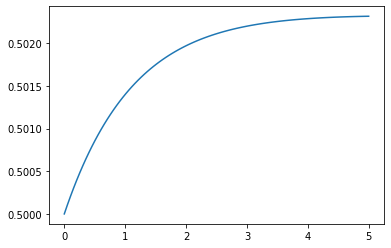

In [23]:
import matplotlib.pyplot as plt
plt.plot(t,y[:,0])

Test:

$$
\frac{\partial^{2}y}{\partial x^{2}} = \sin(x)\;,
$$

or

$$
\begin{align}
\frac{\partial y}{\partial x} &= z\;,\\
\frac{\partial z}{\partial x} &= \sin(x)\;.
\end{align}
$$

In [ ]:
import numpy as np
Nx = 100
x  = np.linspace(0,2*np.pi,Nx)
yz = np.zeros((Nx,2))
dx = x[1]-x[0]

def rhs(x,y):
    rhs_local = np.zeros(2)
    rhs_local[0] = y[1]
    rhs_local[1] = np.sin(x)
    return rhs_local

# Set initial condition
yz[0][0] = 0
yz[0][1] = -1
for i in range(1,Nx):
    yz[i] = rk4(x[i-1],yz[i-1],dx)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x,yz[:,0])
plt.plot(x,-np.sin(x))

In [ ]:
# import numpy as np
# import scipy.integrate as si
# import matplotlib.pyplot as plt
# from scipy.special import kn as Kn
# from IPython.display import Image

# def Q_single_integrand_1(q):
#     return np.exp(-q)/q * Kn(1,q) * (q-qnu_local)**2

# def Q_single_integrand_2(x):
#     return np.exp(-2.0*qnu_local*x) * np.sqrt(x**2-x)/x**3

# def fit(q):
#     return 0.234 * (2.0*q)**2.4 * np.exp(-1.1*(2.0*q))

# def rel_err(a,b):
#     if a != 0.0:
#         return np.abs(1.0-b/a)
#     elif b != 0.0:
#         return np.abs(1.0-a/b)
#     else:
#         return 0.0

# N   = 1000
# qnu = np.linspace(0,50,N)
# I1  = np.zeros(N)
# I2  = np.zeros(N)
# for i in range(N):
#     qnu_local = qnu[i]
#     I1[i] = si.quad(Q_single_integrand_1,a=qnu_local,b=np.inf)[0]
#     I2[i] = si.quad(Q_single_integrand_2,a=1,b=np.inf)[0]

# fs = 12
# lw = 1
# fig, ax = plt.subplots(figsize=(3.54*1.25,3.54*3/4*1.25),dpi=300)
# ax.set_xlabel(r"$q_{\nu}=\epsilon_{\nu}/2T$",fontsize=fs)
# ax.set_ylabel(r"$\mathcal{Q}_{\rm factor}(q_{\nu})$",fontsize=fs)

# I1_plot  = 2310/2048 * (2*qnu)**3 * I1
# I2_plot  = 2310/2048 * (2*qnu)**3 * I2
# fit_plot = fit(qnu)

# leg1 = ax.plot(qnu,I1_plot, c='blue'  ,ls='-' ,label=r"$I_{1}$",lw=lw)
# leg2 = ax.plot(qnu,I2_plot, c='orange',ls='--',label=r"$I_{2}$",lw=lw)
# leg3 = ax.plot(qnu,fit_plot,c='green' ,ls="-.",label="Fit"     ,lw=lw)

# fit_errors  = np.zeros(N)
# abs_errors  = np.zeros(N)
# claimed_err = np.zeros(N)
# for i in range(N):
#     I1_plot[i] = np.maximum(I1_plot[i],1e-15)
#     I2_plot[i] = np.maximum(I2_plot[i],1e-15)
#     fit_plot[i] = np.maximum(fit_plot[i],1e-15)
#     err = rel_err(I1_plot[i],fit_plot[i])
#     fit_errors[i]  = np.log10(np.maximum(err,1e-15))
#     abs_errors[i]  = np.log10(np.maximum(np.abs(I1_plot[i]-fit_plot[i]),1e-15))
#     claimed_err[i] = np.log10(np.maximum(0.03*I1_plot[i],1e-15))

# ax_left = ax.twinx()
# ax_left.set_ylabel(r"$\log_{10}\mathrm{Error}$",fontsize=fs)
# leg4 = ax_left.plot(qnu[1:],fit_errors[1:],c='red' ,ls=":",label = "Rel. Error", lw=lw)
# leg5 = ax_left.plot(qnu[1:],abs_errors[1:],c='magenta' ,ls=":",label = "Abs. Error", lw=lw)
# leg6 = ax_left.plot(qnu,claimed_err,c='cyan',label=r"$0.03I_{1}$",lw=lw)

# leg_all = leg1+leg2+leg3+leg4+leg5+leg6
# leg_abs = [l.get_label() for l in leg_all]

# ax.legend(leg_all,leg_abs,loc=5)
# ax.grid()

# outfig = "NNBrems_fit_vs_integral.png"
# plt.savefig(outfig,dpi=300,bbox_inches='tight',facecolor='white')
# plt.close(fig)
# Image(outfig)

In [ ]:
# N   = 1000000
# qnu = np.linspace(0,10000,N)
# I   = np.zeros(N)
# for i in range(N):
#     qnu_local = qnu[i]
#     I[i] = si.quad(Q_single_integrand_1,a=qnu_local,b=np.inf)[0]

# I_int   = 2310/2048 * (2*qnu)**3 * I
# fit_int = fit(qnu)

# print("From fit : %.8lf"%(np.trapz(fit_int,x=qnu)*2))
# print("From orig: %.8lf"%(np.trapz(I_int,x=qnu)*2))

The neutrino number emission factor is obtained from

$$
\RR_{\rm factor}(\epsilon_{\nu}) = \frac{\QQ_{\rm factor}(\epsilon_{\nu})}{2q_{\nu}} = 0.234 \bigl(2q_{\nu}\bigr)^{1.4} e^{-1.1(2q_{\nu})}.
$$

We can now integrate these factors, obtaining

$$
\int_{0}^{\infty}d\epsilon_{\nu}\,\RR_{\rm factor}(\epsilon_{\nu})=0.234 \int_{0}^{\infy\bigl(2q_{\nu}\bigr)^{1.4} e^{-1.1(2q_{\nu})}
$$

In [ ]:
# def Q_integrand(x):
#     return 0.234 * x**2.4 * np.exp(-1.1*x)

# def R_integrand(x):
#     return Q_integrand(x)/x

# Q_factor = si.quad(Q_integrand,a=0,b=np.inf)[0]
# R_factor = si.quad(R_integrand,a=0,b=np.inf)[0]
# print("Q_factor = %.8lf\nR_factor = %.8lf"%(Q_factor,R_factor))